<a href="https://colab.research.google.com/github/Pankaj-2003/Computer_Vision_Project/blob/main/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1:

In [3]:
import os
# !pip install torchmetrics
import zipfile

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
# from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

from u2net import U2NET  # You'll need to import the U-2-Net architecture

In [4]:
zip_paths = ['/content/Image-20240807T073037Z-001.zip' , '/content/Mask-20240807T073036Z-001.zip'] #list of names of zip files

for zip_path in zip_paths: # iterating over those files
  with zipfile.ZipFile(zip_path, 'r') as zip_ref: # extracting folder inside them
      zip_ref.extractall()

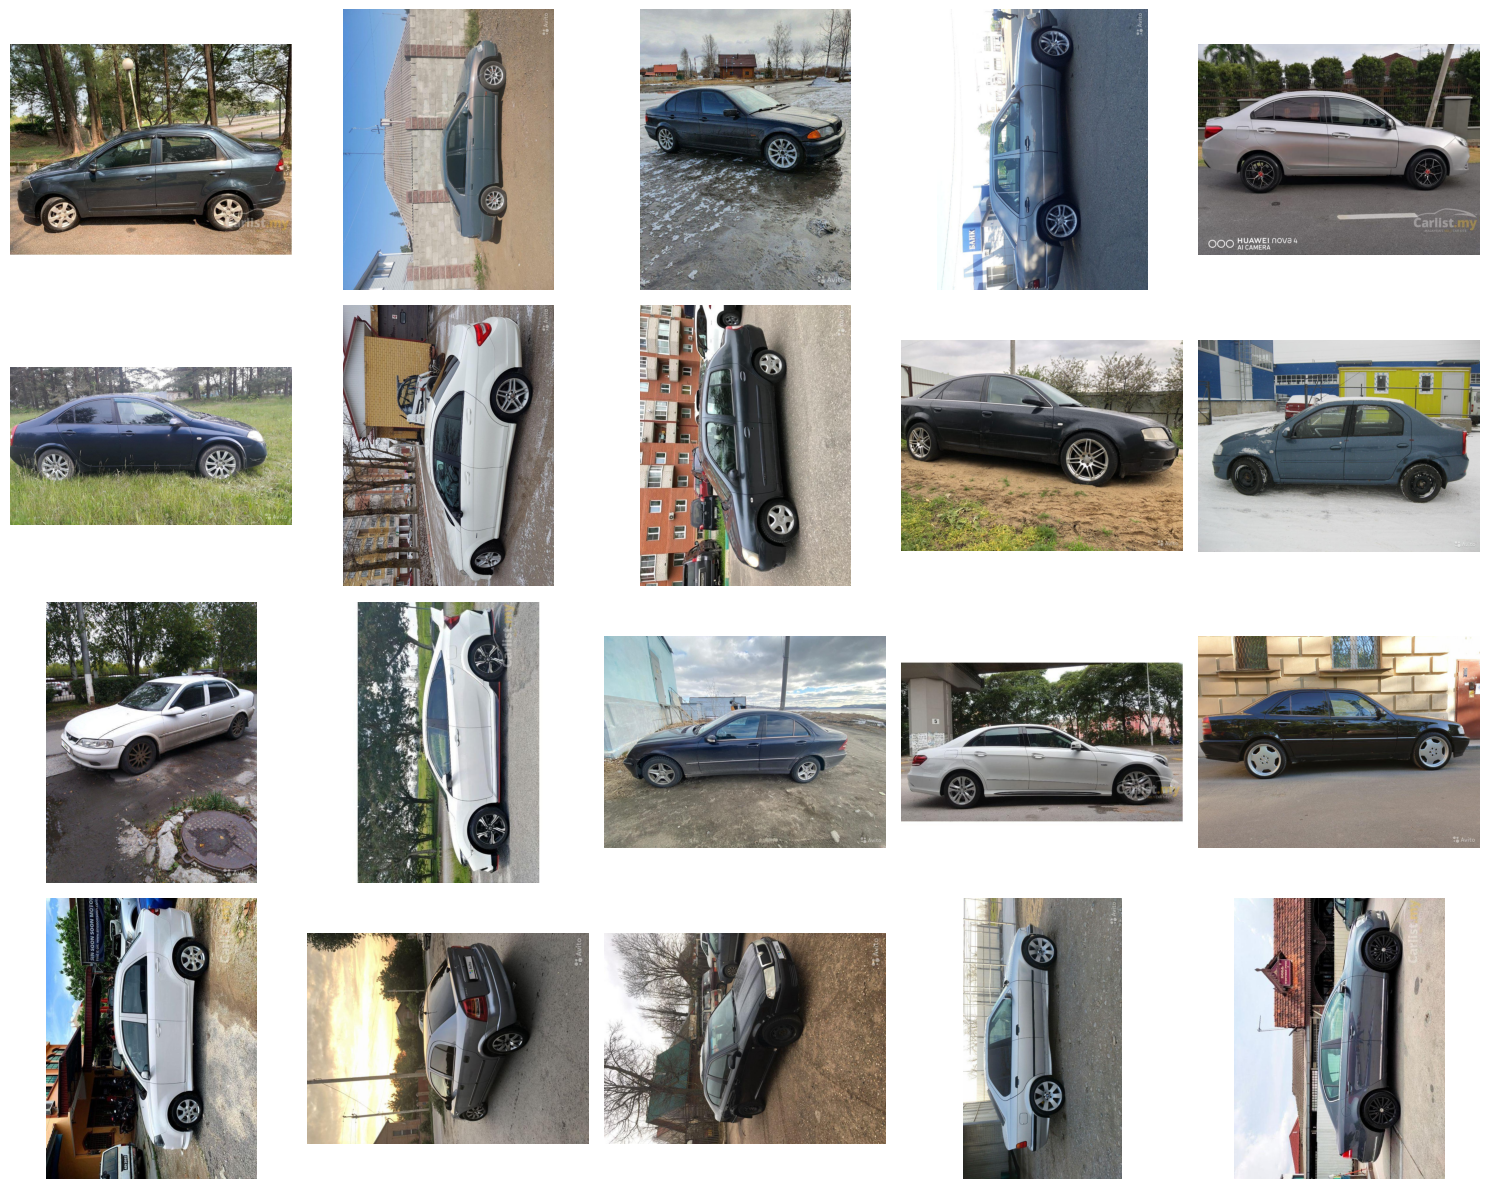

In [3]:
folder_image = "/content/Image" # folder path of images
images = [Image.open(os.path.join(folder_image , f)) for f in os.listdir(folder_image)] # displaying every image present in images folder
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for ax, img in zip(axes.ravel(), images):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


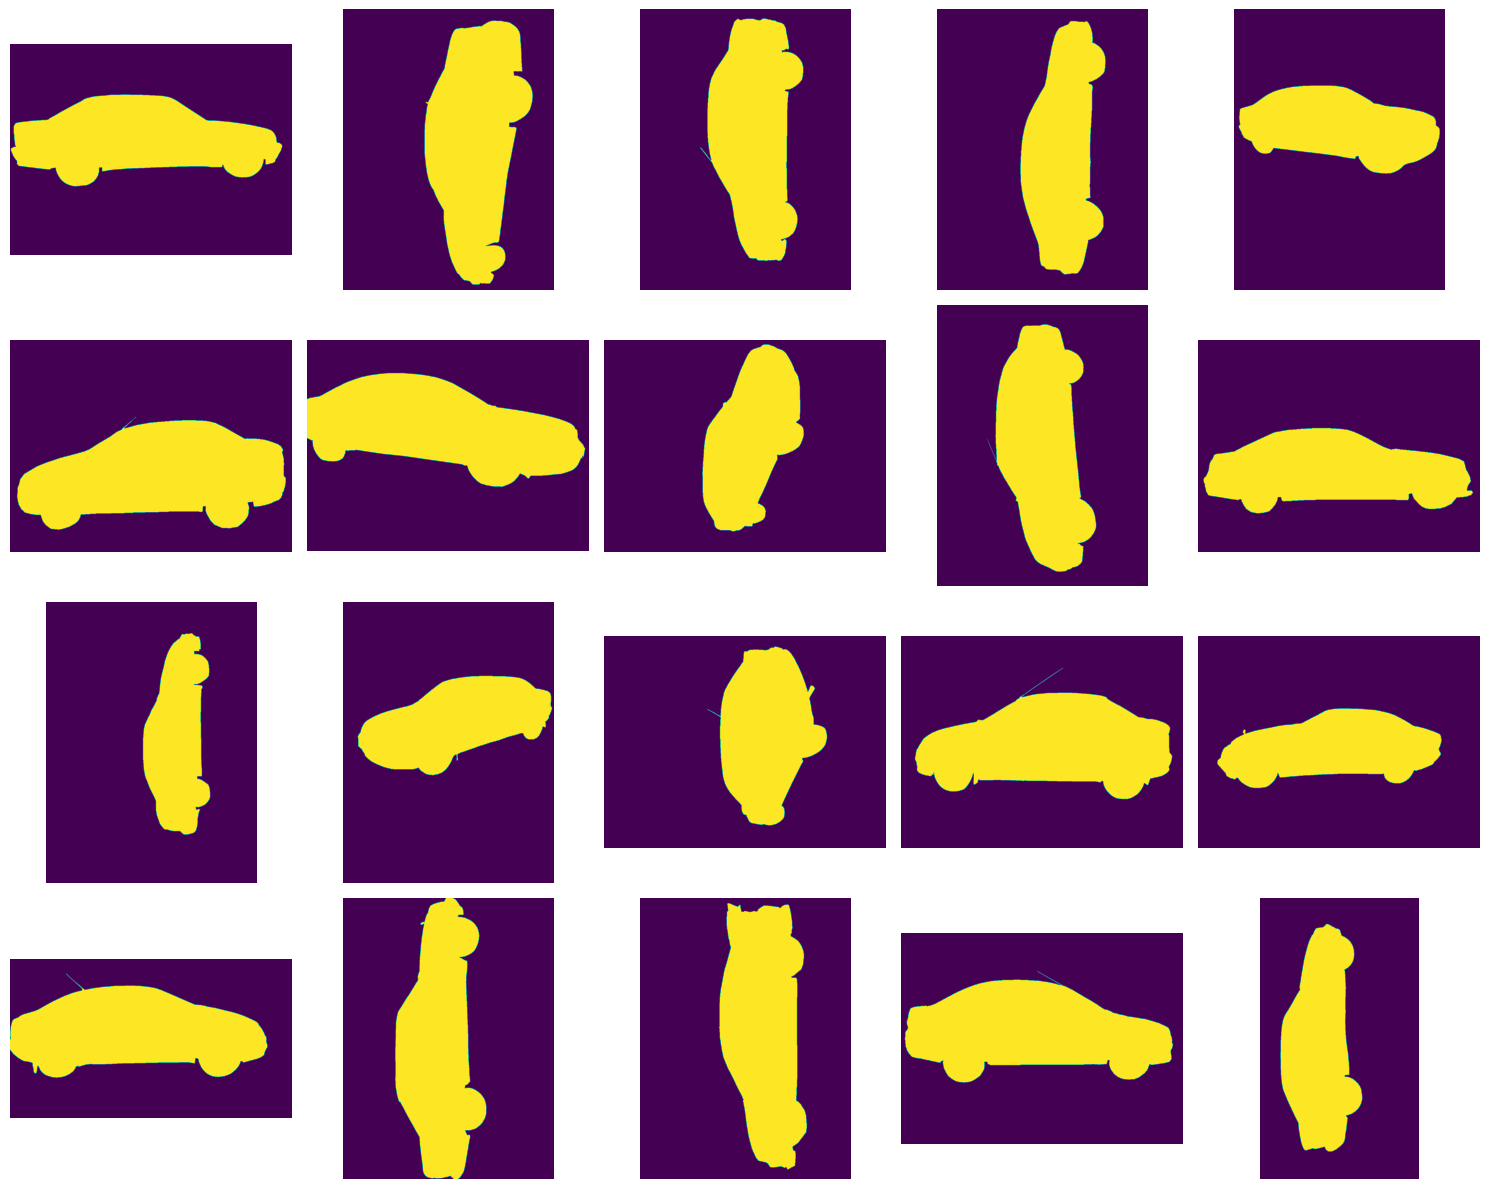

In [4]:
folder_mask = "/content/Mask" # folder path of masks
masks = [Image.open(os.path.join(folder_mask , f)) for f in os.listdir(folder_mask)] # displaying every mask present in mask folder
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for ax, img in zip(axes.ravel(), masks):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
class CarSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_ext=".jpg", mask_ext=".png", transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ext = image_ext
        self.mask_ext = mask_ext
        self.transform = transform
        self.images = [os.path.splitext(f)[0] for f in os.listdir(image_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name + self.image_ext)
        mask_path = os.path.join(self.mask_dir, img_name + self.mask_ext)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Converting to binary mask
        mask = mask.point(lambda x: 0 if x < 150 else 255, '1')

        if self.transform:
            image_transform = transforms.Compose([
                transforms.Resize((320, 320)),
                transforms.ToTensor()
            ])
            mask_transform = transforms.Compose([
                transforms.Resize((320, 320), interpolation=Image.NEAREST)
            ])

            image = image_transform(image)
            mask = mask_transform(mask)

            mask = torch.from_numpy(np.array(mask)).float().unsqueeze(0)
            mask = (mask > 0.5).float()  # Ensure binary

        return image, mask

In [6]:
# Data Transforms and Splitting the Dataset
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

image_dir = '/content/Image'
mask_dir = '/content/Mask'
dataset = CarSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
# Split dataset into training and validation sets
train_size = 15
val_size = 5
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [7]:
from u2net import U2NET

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = U2NET(3, 1)  # 3 input channels (RGB), 1 output channel (mask)
model = model.to(device)

# Define Loss Function and Optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [9]:
def dice_score(pred, target, smooth=1e-6):
    # Flatten prediction and target tensors
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def iou_score(pred, target, smooth=1e-6):
    # Flatten prediction and target tensors
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim


# Use a combination of BCE and Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight = weight

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        pred = torch.sigmoid(pred)
        dice_loss = 1 - dice_score(pred, target)
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs[0], masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    if epoch % 5 == 0:  # Calculate metrics every 5 epochs
        model.eval()
        val_loss = 0
        dice_scores = []
        iou_scores = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs[0], masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs[0])
                preds = (preds > 0.5).float()

                dice_scores.append(dice_score(preds, masks))
                iou_scores.append(iou_score(preds, masks))

        avg_dice = sum(dice_scores) / len(dice_scores)
        avg_iou = sum(iou_scores) / len(iou_scores)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Dice Score: {avg_dice:.4f}, "
              f"IoU: {avg_iou:.4f}")

        # Adjust learning rate
        scheduler.step(val_loss)

print("Training completed!")

Epoch [1/200], Train Loss: 0.6669, Val Loss: 0.6295, Dice Score: 0.4527, IoU: 0.2935
Epoch [6/200], Train Loss: 0.5998, Val Loss: 0.5833, Dice Score: 0.5413, IoU: 0.3727
Epoch [11/200], Train Loss: 0.5854, Val Loss: 0.5720, Dice Score: 0.5535, IoU: 0.3840
Epoch [16/200], Train Loss: 0.5777, Val Loss: 0.5616, Dice Score: 0.5800, IoU: 0.4097
Epoch [21/200], Train Loss: 0.5793, Val Loss: 0.5719, Dice Score: 0.6258, IoU: 0.4577
Epoch [26/200], Train Loss: 0.5738, Val Loss: 0.5622, Dice Score: 0.6419, IoU: 0.4758
Epoch [31/200], Train Loss: 0.5763, Val Loss: 0.5608, Dice Score: 0.6662, IoU: 0.5016
Epoch [36/200], Train Loss: 0.5705, Val Loss: 0.5590, Dice Score: 0.6677, IoU: 0.5035
Epoch [41/200], Train Loss: 0.5717, Val Loss: 0.5589, Dice Score: 0.6863, IoU: 0.5250
Epoch [46/200], Train Loss: 0.5725, Val Loss: 0.5604, Dice Score: 0.7061, IoU: 0.5480
Epoch [51/200], Train Loss: 0.5728, Val Loss: 0.5596, Dice Score: 0.7143, IoU: 0.5578
Epoch [56/200], Train Loss: 0.5773, Val Loss: 0.5588, Di

## Task 2: Training the same model with loss as dice_score

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        # Flatten prediction and target tensors
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs[0], masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    if epoch % 5 == 0:  # Calculate metrics every 5 epochs
        model.eval()
        val_loss = 0
        dice_scores = []
        iou_scores = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs[0], masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs[0])
                preds = (preds > 0.5).float()

                dice_scores.append(1 - loss.item())  # Dice score is 1 - Dice Loss
                iou_scores.append(iou_score(preds, masks))

        avg_dice = sum(dice_scores) / len(dice_scores)
        avg_iou = sum(iou_scores) / len(iou_scores)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Dice Score: {avg_dice:.4f}, "
              f"IoU: {avg_iou:.4f}")

        # Adjust learning rate
        scheduler.step(val_loss)

print("Training completed!")

Epoch [1/200], Train Loss: 0.5567, Val Loss: 0.5828, Dice Score: 0.4172, IoU: 0.3360
Epoch [6/200], Train Loss: 0.5509, Val Loss: 0.5269, Dice Score: 0.4731, IoU: 0.4679
Epoch [11/200], Train Loss: 0.5482, Val Loss: 0.5286, Dice Score: 0.4714, IoU: 0.6252
Epoch [16/200], Train Loss: 0.5436, Val Loss: 0.5191, Dice Score: 0.4809, IoU: 0.6231
Epoch [21/200], Train Loss: 0.5458, Val Loss: 0.5223, Dice Score: 0.4777, IoU: 0.6400
Epoch [26/200], Train Loss: 0.5430, Val Loss: 0.5211, Dice Score: 0.4789, IoU: 0.6422
Epoch [31/200], Train Loss: 0.5419, Val Loss: 0.5206, Dice Score: 0.4794, IoU: 0.6524
Epoch [36/200], Train Loss: 0.5428, Val Loss: 0.5179, Dice Score: 0.4821, IoU: 0.6598
Epoch [41/200], Train Loss: 0.5440, Val Loss: 0.5198, Dice Score: 0.4802, IoU: 0.7055
Epoch [46/200], Train Loss: 0.5428, Val Loss: 0.5167, Dice Score: 0.4833, IoU: 0.6911
Epoch [51/200], Train Loss: 0.5405, Val Loss: 0.5182, Dice Score: 0.4818, IoU: 0.6823
Epoch [56/200], Train Loss: 0.5430, Val Loss: 0.5172, Di

## Task 3: Designing a logic/algorithm/ML model to differentiate between horizontal and Vertical cars

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input











In [13]:
# Load pre-trained VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path)
    img_array = img_to_array(img)

    # Resize the longer side to 224 while maintaining aspect ratio
    aspect = img_array.shape[1] / img_array.shape[0]
    if img_array.shape[0] > img_array.shape[1]:
        new_shape = (224, int(224 * aspect))
    else:
        new_shape = (int(224 / aspect), 224)

    img_resized = tf.image.resize(img_array, new_shape)

    # Pad to 224x224
    img_padded = tf.image.resize_with_pad(img_resized, 224, 224)

    img_processed = preprocess_input(img_padded)
    return np.expand_dims(img_processed, axis=0)

In [15]:
# Modify the VGG16 model to use global average pooling
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

def extract_features(image_path):
    img_array = load_and_preprocess_image(image_path)
    features = model.predict(img_array)
    return features.flatten()

In [16]:
# Load and extract features from all images
image_dir = '/content/Image'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

features_list = []
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    features = extract_features(image_path)
    features_list.append(features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [17]:
# Convert to numpy array
X = np.array(features_list)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


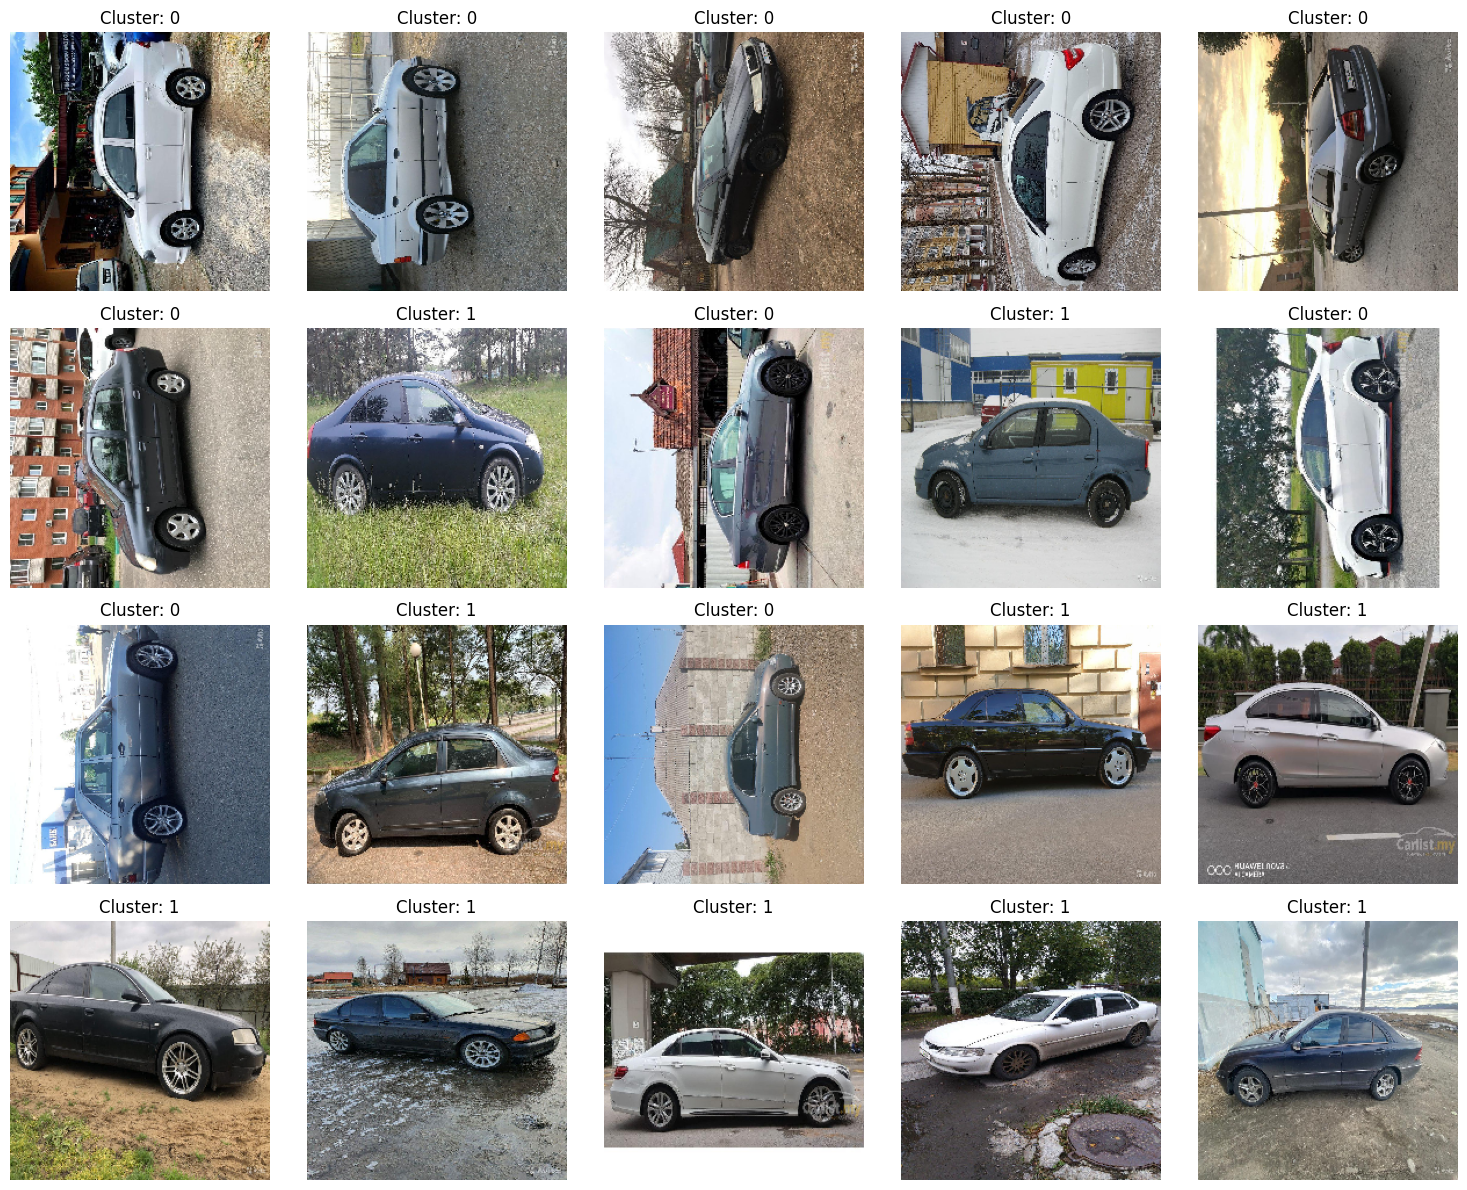

Cluster distribution:
Cluster 0: 10
Cluster 1: 10


In [18]:
# Visualize results
def plot_images(images, labels):
    rows = (len(images) + 4) // 5  # Calculate rows needed for 5 columns
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3*rows))
    axes = axes.ravel()

    for i in range(len(images)):
        img = load_img(os.path.join(image_dir, images[i]), target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].set_title(f"Cluster: {labels[i]}")
        axes[i].axis('off')

    # Turn off any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Plot some sample images with their cluster labels
plot_images(image_files[:], cluster_labels[:])

# Print cluster distribution
print("Cluster distribution:")
print(f"Cluster 0: {sum(cluster_labels == 0)}")  # horizontal
print(f"Cluster 1: {sum(cluster_labels == 1)}")  # vertical

In [ ]:
b

True